<h1 align="center">Programming for Business Analytics</h1> 
<h2 align="center"> COMPGC27/MSING055</h2> 
<h2 align="center"> Group Coursework, Milestone 3</h2>

<h3 align="center">Team 14</h3>


| Member                | Email                         |
|:----------------------|:------------------------------|
|   Katerina Klimova      | katerina.klimova.16@ucl.ac.uk |
|   Lu Wang               | l.wang.16@ucl.ac.uk           |
|   Mesut Can Alkan       | mesut.alkan.16@ucl.ac.uk      |
|   Alexandros Baltas     | alexandros.baltas.16@ucl.ac.uk|
|   Dimitri Visnadi       | dimitri.visnadi.16@ucl.ac.uk  |


<h4 align="center">**Date:** 9th January 2017</h4>



### Abstract

A Videogame company is about to expand into a new market. We have a dataset at hand that reviews games, platforms, publishers and genres. We will use this data in order to help the company design their strategy for expansion. We start off with some exploratory analysis so we can then design two different models that will help the company identify in which platform and genre they should expand to.

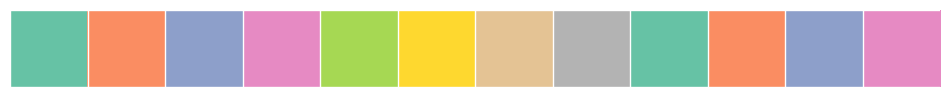

In [1]:
# Import packages 
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib 

sns.set_palette("Set2", 12)
sns.palplot(sns.color_palette())
sns.set_context('talk')

## The CoNVO:
In order to better understand the scope of this project, we briefly guide you through the four parts.
### Business Context: 
Our client is a video game company that produces games for PC. The company has a dataset of competitors’ game reviews at their disposal. This dataset includes reviews of games published for various platforms, the genre, and release dates.
### Needs: 
The company is planning to expand their business to other platforms as well. As they have never expanded to any other platform before, they highly rely on our analysis that will help form their expansion strategy. Their lack of experience is leaving them with a major open questions: Which platform market should they penetrate?
### Vision:
The marketing department will receive a report including the popularity of the gaming platforms over the years and a concluding recommendation which is the most promissing market for them.
### Mockup:
"A gaming company that has only established its marketshare amongst PC games, we can see an opportunity producing games for iOS market. The most promising genre in this market over the upcoming years seems to be action games."

### Import publishers

The original dataset did not have the publisher for each game. The Python code below was used to retrieve the publishers from the website:

In [2]:
import requests
import csv
from html.parser import HTMLParser

class PublisherParser(HTMLParser):

    def __init__(self):
        HTMLParser.__init__(self)
        self.getting_there = False
        self._publisher = None

    def get_publisher(self):
        return self._publisher

    def feed(self, data):
        self.getting_there = False
        self._publisher = None
        HTMLParser.feed(self, data)

    def handle_data(self, data):

        data = data.strip()
        if data == "Publisher":
            self.getting_there = True
        elif data != ":" and self.getting_there:
            self._publisher = data
            self.getting_there = False

class UrlRetriever(object):

    def __init__(self, base):
        self._base_url = base

    def get_base_url(self):
        return self._base_url

    def retrieve(self, url):
        return requests.get(self.get_base_url() + url).text

# --- Uncomment to repeat the process ---
# retriever = UrlRetriever("http://uk.ign.com")
# parser = PublisherParser()

# with open("../data/ign.csv") as f:
#     reader = csv.reader(f, delimiter=',')
#     for row in reader:
#         if row[3] == "url":
#             row.append("Publisher")
#             with open("../data/ign_with_publishers.csv", "w") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)
#         else:
#             parser.feed(retriever.retrieve(row[3]))
#             row.append(parser.get_publisher())
#             with open("../data/ign_with_publishers.csv", "a") as g:
#                 writer = csv.writer(g, delimiter=",")
#                 writer.writerow(row)

## Data Overview
We first have a look at the structure of the data to get an idea. We can see that some values for the column "genre" is missing. In addition, the column "Publisher" is also missing some values, but we can confirm that there was no such information displayed on the website.

In [3]:
# Load data into a data frame using pandas
games_df = pd.read_csv("data/ign_with_publishers.csv")
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18625 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        18625 non-null int64
score_phrase      18625 non-null object
title             18625 non-null object
url               18625 non-null object
platform          18625 non-null object
score             18625 non-null float64
genre             18589 non-null object
editors_choice    18625 non-null object
release_year      18625 non-null int64
release_month     18625 non-null int64
release_day       18625 non-null int64
Publisher         17720 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.7+ MB


## Data cleanup

### Missing values
As mentioned above, while compiling the data by bringing publisher names using url sources, there were still some missing values for publisher names and genre. As the difference was insignificantly small (< 5%), we decided to discard the missing values.

In [4]:
games_df = games_df.dropna()
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17687 entries, 0 to 18624
Data columns (total 12 columns):
Unnamed: 0        17687 non-null int64
score_phrase      17687 non-null object
title             17687 non-null object
url               17687 non-null object
platform          17687 non-null object
score             17687 non-null float64
genre             17687 non-null object
editors_choice    17687 non-null object
release_year      17687 non-null int64
release_month     17687 non-null int64
release_day       17687 non-null int64
Publisher         17687 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 1.8+ MB


## Exploratory analysis
In order to get a better understanding of the data, we began with some exploratory analysis to see the behaviour of the review scores, the platform and the publishers.  

### Score Phrases

There are eleven different score phrases for the scores ranging from 0 to 10. Masterpiece being 10 was followed by Amazing, Great, Good, Okay, Mediocre, Bad, Awful, Painful, Unbearable and Disaster for each point range (e.g 9.0-9.9).

As it can be observed on the table and the graph below, the distribution is skewed to positive score phrases.


In [5]:
games_df.groupby('score_phrase').score.agg(['mean', 'count'])\
    .sort_values('mean')

,mean,count
score_phrase,,
Disaster,0.666667,3
Unbearable,1.272308,65
Painful,2.267485,326
Awful,3.287658,632
Bad,4.333223,1210
Mediocre,5.316865,1850
Okay,6.362283,2768
Good,7.369226,4520
Great,8.316648,4553


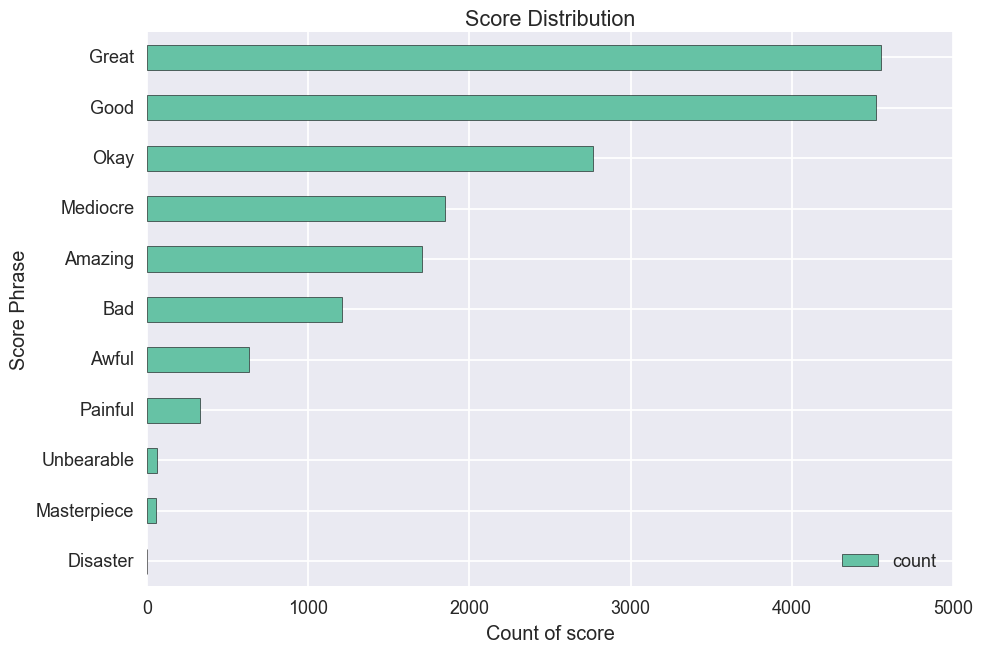

In [6]:
# Score Distribution plot
plt.figure(figsize=(8,4))
score_phrase_count = games_df.groupby('score_phrase')\
    .score.agg(['count'])
score_phrase_count = score_phrase_count.sort_values('count')
score_phrase_count.plot(kind='barh')
plt.ylabel("Score Phrase")
plt.xlabel("Count of score")
plt.title("Score Distribution")
plt.legend(loc=4)

## Outlier
There was one game with the release year 1970 for the Xbox. As this is clearly a mistake we discarded that entry.

In [7]:
games_df = games_df[games_df.release_year > 1970]

### Platform names
Platform names slightly evolved for some categories over the historical period. Such as Play Station, then Play Station 2, Play Station 3, 4, Portable, Vita etc. Consequently, we have mapped again and unified these platform names. For instance, we used Nintendo for all nintendo-related platforms.
We have also unified all iPad, iPhone and iPod platform names as these look alike.

### Publisher names
As publisher names may include different company names under the same group, we followed the same methodology as the platform names. For example, Sierra, Sierra Attractions, Sierra On-Line, Sierra Sports, Sierra Studios were all unified due to being part of Sierra Entertainment. So, we applied the same rule to publisher names if they look alike.

In [8]:
games_df = games_df.replace(["Xbox 360", "Xbox One"], "Xbox")
games_df = games_df.replace(["PlayStation", \
    "PlayStation 2", "PlayStation 3","PlayStation 4",\
    "PlayStation Portable", "PlayStation Vita"],\
                            "PlayStation")
games_df = games_df.replace(["Nintendo 3DS","Nintendo 64",\
                             "Nintendo 64DD","Nintendo DS",\
                             "Nintendo DSi"], "Nintendo")
games_df = games_df.replace(["iPad","iPhone","iPod"], "iOS")
games_df = games_df.replace(["Game Boy","Game Boy Advance",\
                             "Game Boy Color"], "Game Boy")
games_df = games_df.replace(["WonderSwan","WonderSwan Color"],\
                            "WonderSwan")
games_df = games_df.replace(["Wii", "Wii U"], "Wii")
games_df = games_df.replace(["TurboGrafx-16", "TurboGrafx-CD"],\
                            "TurboGrafx")
games_df = games_df.replace(["Sega 32X", "Sega CD"], "Sega")
games_df = games_df.replace(["NeoGeo", "NeoGeo Pocket Color"],\
                            "NeoGeo")
games_df = games_df.replace(["Dreamcast", "Dreamcast VMU"],\
                            "Dreamcast")
games_df = games_df.replace(["Atari 2600", "Atari 5200"],\
                            "Atari")


games_df = games_df.replace(["Sierra","Sierra Attractions",\
                             "Sierra On-Line",\
                             "Sierra Sports","Sierra Studios"],\
                            "Sierra")
games_df = games_df.replace(["Sony BMG Music Entertainment",\
                             "Sony Computer Entertainment",\
                             "Sony Online Entertainment",\
                             "Sony Pictures Entertainment",\
                             "Sony Pictures Mobile"], "Sony")
games_df = games_df.replace(["Atari","Atari Corp. (1984-2003)",\
                             "Atari Games"], "Atari")
games_df = games_df.replace(["Namco","Namco Hometek",\
                             "Namco Networks"], "Namco")
games_df = games_df.replace(["SNK","SNK NeoGeo","SNK Playmore"],\
                            "SNK")
games_df = games_df.replace(["Square Enix",\
                             "Square Enix Collective",\
                             "Square Enix Mobile"], \
                            "Square Enix")
games_df = games_df.replace(["11 Bit Studio","11 Bit Studios"],\
                            "11 Bit Studio")
games_df = games_df.replace(["Bandai","Bandai Namco Games"],\
                            "Bandai")
games_df = games_df.replace(["Capcom","Capcom Mobile"],\
                            "Capcom")
games_df = games_df.replace(["Commodore","Commodore Gaming"],\
                            "Commodore")
games_df = games_df.replace(["HeadGames","HeadGames Publishing"],\
                            "HeadGames")
games_df = games_df.replace(["Humongous","Humongous Entertainment"],\
                            "Humongous")
games_df = games_df.replace(["Intense","Intense Games"], "Intense")
games_df = games_df.replace(["LEGO Interactive","LEGO Media"], "LEGO")
games_df = games_df.replace(["SEGA","SEGA Mobile"], "SEGA")
games_df = games_df.replace(["THQ","THQ Wireless"], "THQ")


### Data Analysis & Visualization

Following the structuring and mapping process, we visualised the data with the number of the games on different platforms over the historical period. 

* Most successful platforms over last decade: PlayStation, PC, Xbox, Nintendo, Wii, and iOS
* Out of life: Wireless, GameCube, Dreamcast, Game Boy
* Long performer: PlayStation, PC, Xbox



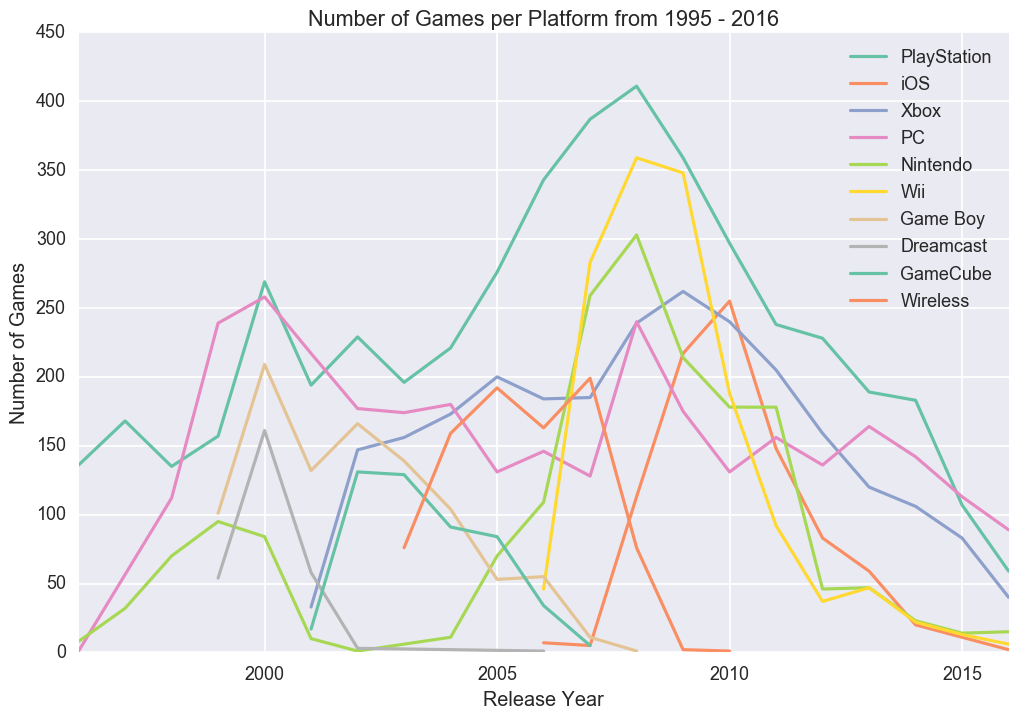

In [9]:
# Number of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
labels = []
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        labels.append(platform)
        ax = games_df[games_df.platform == platform].groupby\
            (['release_year']).size().plot()
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games per Platform from 1995 - 2016")

## The Big Players
The top publisher by far is Electronic Arts, followed by Ubisoft, Activision, and Nintendo. We can see that the majority of published games are produced by the top 10 companies. Besides the Top 10 game producers, we can say that the industry seems to be widely scattered with a large number of smaller incumbents. 

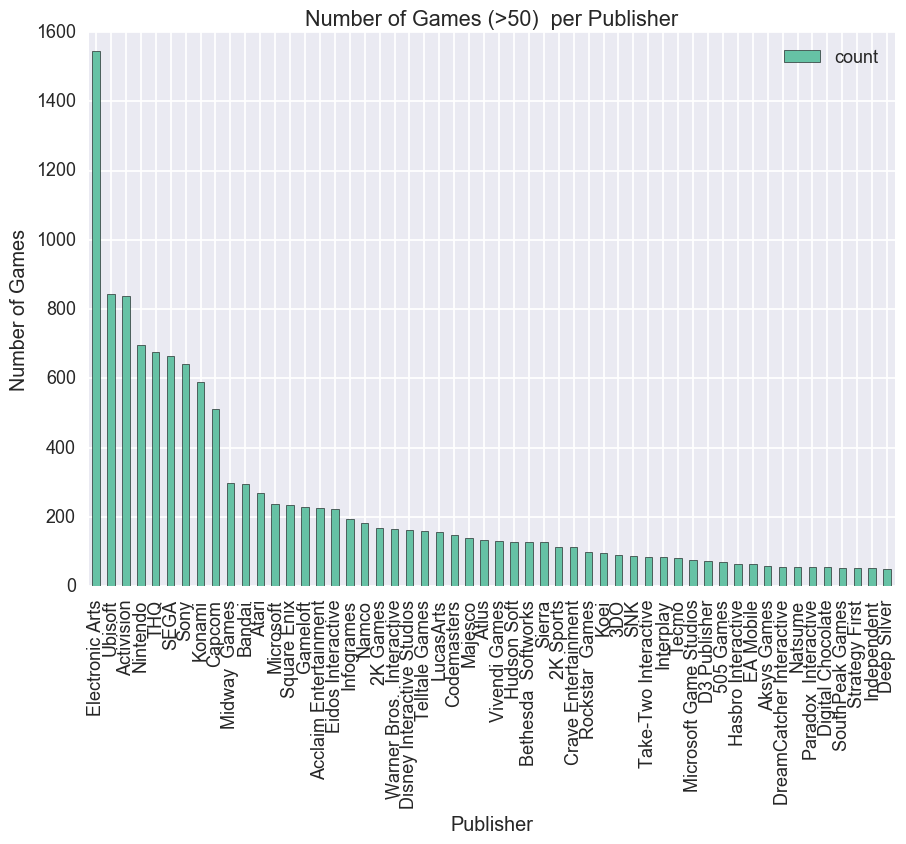

In [10]:
# Number of Games (>50)  per Publisher
plt.figure(figsize=(12,8))
publisher_numbers=games_df.groupby('Publisher').score.agg(['count'])
publisher_numbers=publisher_numbers[publisher_numbers['count']>50]\
    .sort_values('count',ascending=False)
publisher_numbers.plot(kind='bar',stacked=True)
plt.xlabel("Publisher")
plt.ylabel("Number of Games")
plt.title("Number of Games (>50)  per Publisher")

### Publishers
We compute and display the average score per publishers. You can see a tendency that some companies' games are better reviewed than others.

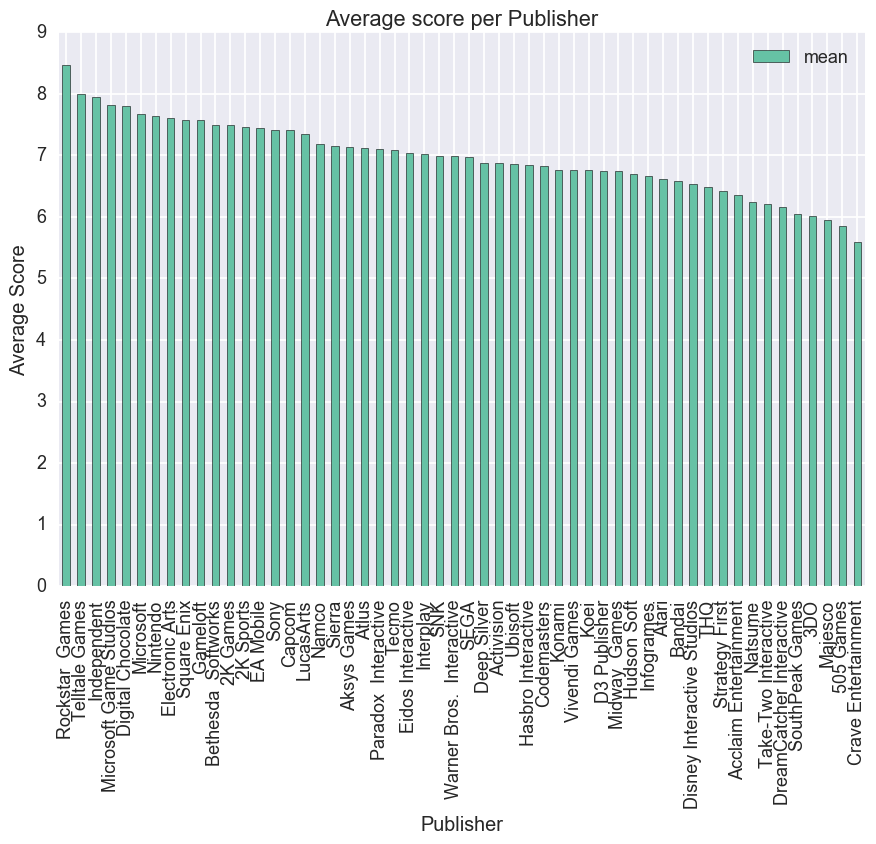

In [11]:
# Average score per Publisher
plt.figure(figsize=(12,8))
publisher_scores=games_df.groupby('Publisher').score\
    .agg(['mean','count'])
publisher_scores=publisher_scores[publisher_scores['count']>50]\
    .sort_values('mean',ascending=False)
publisher_scores = publisher_scores.drop('count', 1)
publisher_scores.plot(kind='bar',stacked=True)
plt.xlabel("Publisher")
plt.ylabel("Average Score")
plt.title("Average score per Publisher")

## Genre
Looking at the genre we can definitely see a trend that some categories of games are more popular than others.

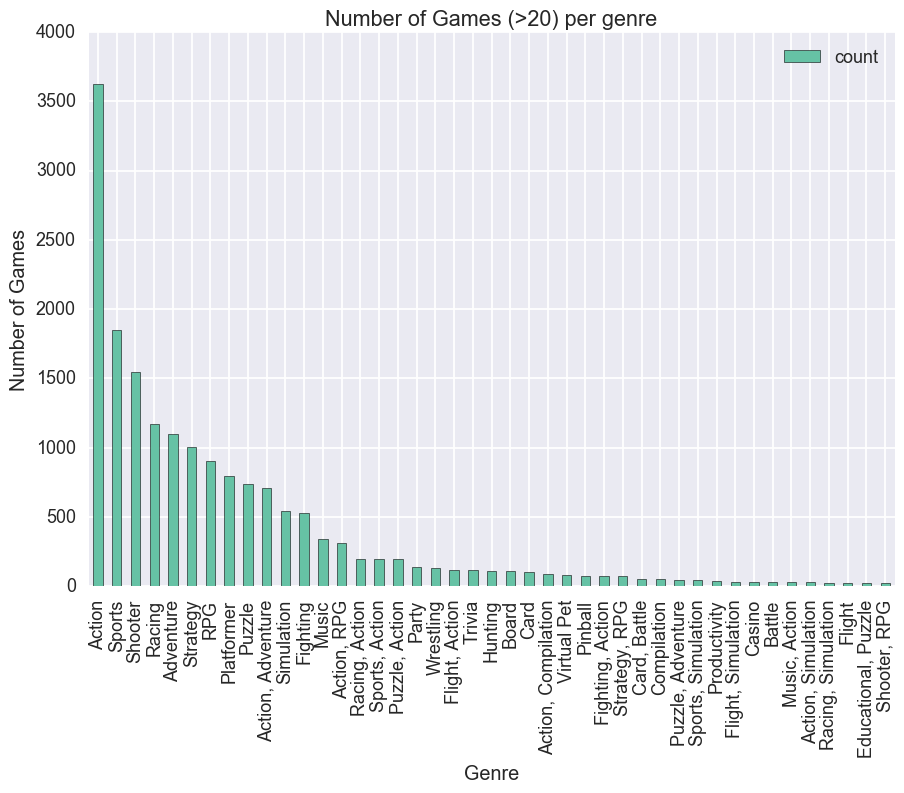

In [12]:
# plot genre--numbers of games
plt.figure(figsize=(12,8))
genre_numbers=games_df.groupby('genre').score.agg(['count'])
genre_numbers=genre_numbers[genre_numbers['count']>20]\
    .sort_values('count',ascending=False)
genre_numbers.plot(kind='bar',stacked=True)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Number of Games (>20) per genre")

Generally, the ratings amongst different platforms seem to be consistent. This leads to the hypothesis that the success is less depending on the platform but more on the genre.

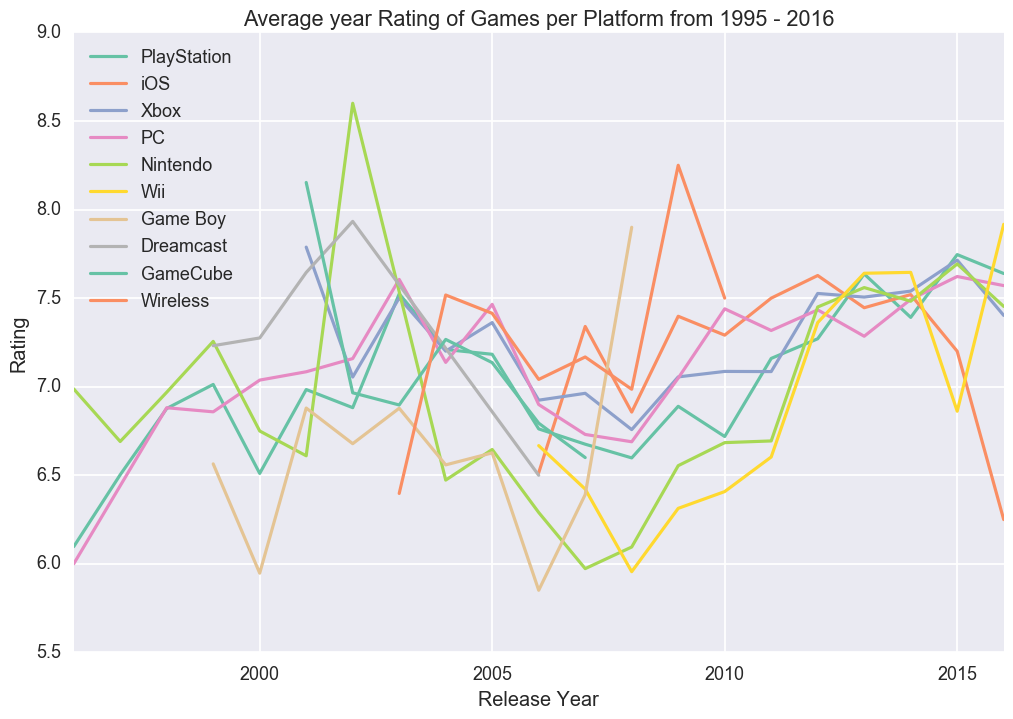

In [13]:
# Average year Rating of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
labels=[]
for platform in games_df.platform.unique():  
    temp = games_df[games_df.platform == platform]
    if temp.shape[0] > 200:
        ax = games_df[games_df.platform == platform]\
            .groupby(['release_year']).score.mean().plot()
        labels.append(platform)
ax.legend(labels, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

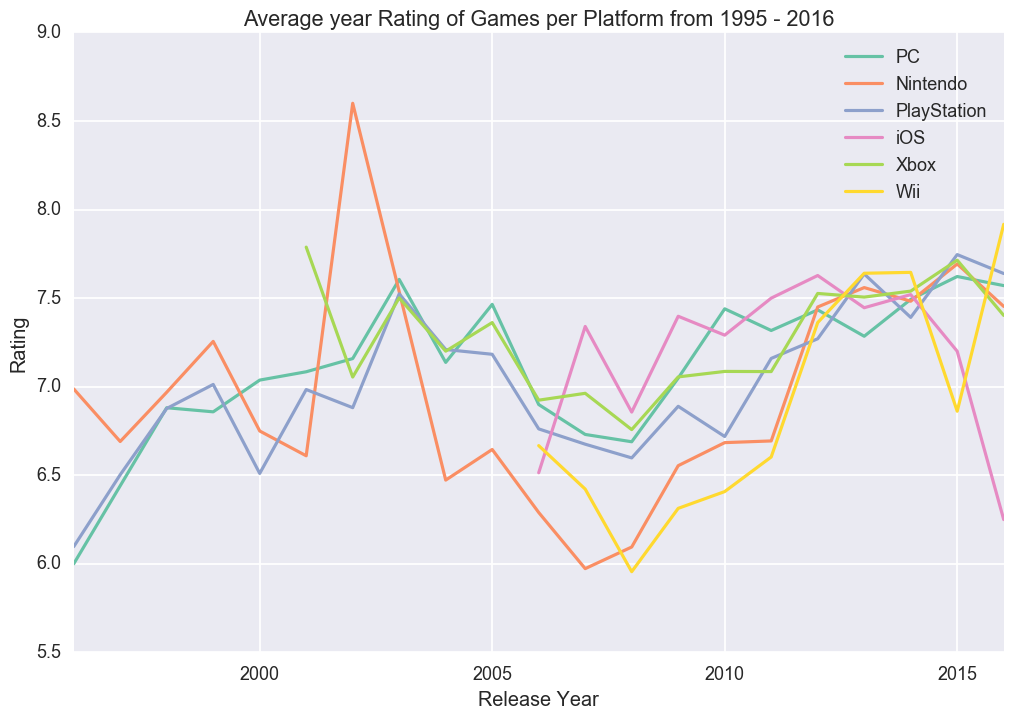

In [14]:
# Average year Rating of Games per Platform from 1995 - 2016
plt.figure(figsize=(12,8))
platfroms_list = ["PC", "Nintendo", "PlayStation", "iOS", "Xbox"\
                  , "Wii"]
for p in platfroms_list:  
    ax = games_df[games_df.platform == p].groupby(['release_year'])\
    .score.mean().plot()
ax.legend(platfroms_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Platform from 1995 - 2016")

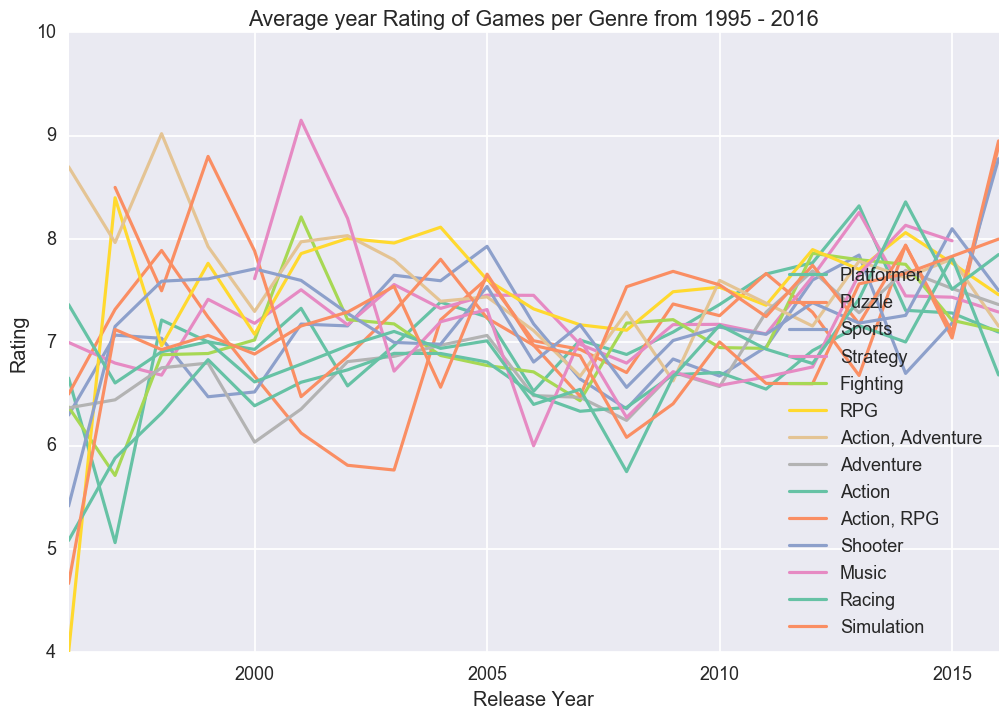

In [15]:
# Average year Rating of Games per Genre from 1995 - 2016
plt.figure(figsize=(12,8))
genres_list=[]
for genre in games_df.genre.unique():  
    temp = games_df[games_df.genre == genre]
    if temp.shape[0] > 200:
        ax = games_df[games_df.genre == genre]\
        .groupby(['release_year']).score.mean().plot()
        genres_list.append(genre)
ax.legend(genres_list, loc='best')
plt.xlabel("Release Year")
plt.ylabel("Rating")
plt.title("Average year Rating of Games per Genre from 1995 - 2016")

## Platform vs Genre
Looking at the matrix below, it is easy to identify how platforms were reviewed in different genres.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


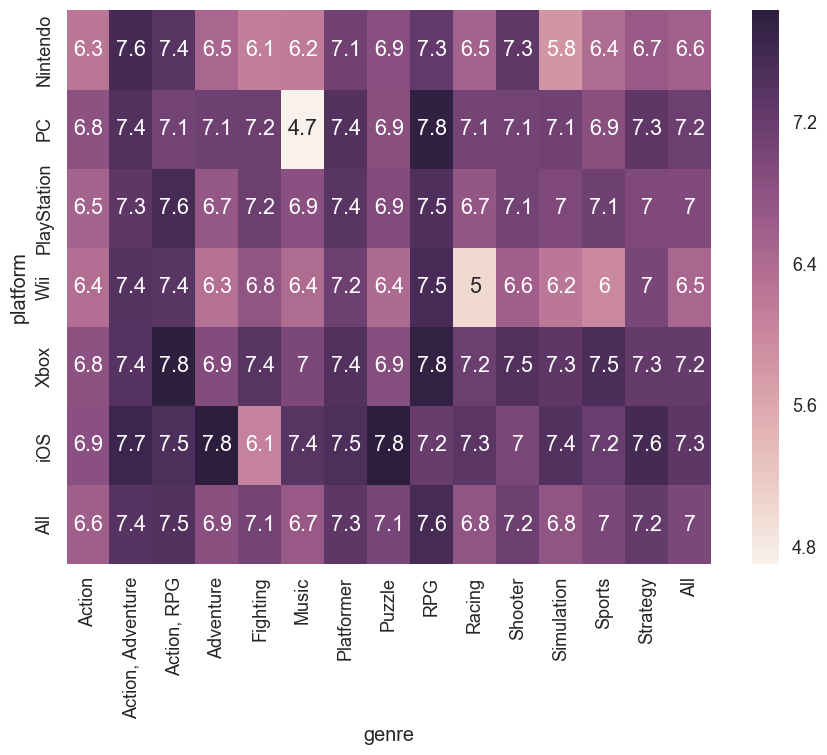

In [16]:
#  Confusuion matrix - Platform vs Genre
table_avg_score = pd.pivot_table(games_df[games_df.platform\
        .isin(platfroms_list)][games_df.genre.isin(genres_list)]
        ,values=['score'],columns=['genre'],index=['platform']\
        ,aggfunc=np.average,margins=True)


ax=sns.heatmap(table_avg_score['score'], annot = True)

### Timeline graph of platfoms

In the timeline graph that follows, it can be seen that games are still released for only a handfull of platforms.

In [17]:
# create new date column
games_df['Date'] = games_df.apply(lambda \
            row: datetime(row['release_year'],\
            row['release_month'], row['release_day']), axis=1)

In [18]:
# Filling up new dataframe for timeline 
df_timeline = pd.DataFrame(games_df['platform'])
df_timeline = df_timeline.drop_duplicates()
df_timeline = df_timeline.reset_index(drop=True)
games_df = games_df.reset_index(drop=True)

df_timeline['year_min'] = pd.to_datetime('2017-01-01 00:00')
df_timeline['year_max'] = pd.to_datetime('1950-01-01 00:00')

In [19]:
# New dataframe only including the first and last releast date
#for each platform
for i in range(len(df_timeline)):
    for j in range(len(games_df)):
        try:
            if df_timeline['platform'][i] == games_df['platform'][j]\
            and df_timeline['year_min'][i] > games_df['Date'][j]: 
                df_timeline['year_min'][i] = games_df['Date'][j]
            
            if df_timeline['platform'][i] == games_df['platform'][j]\
            and df_timeline['year_max'][i] < games_df['Date'][j]: 
                df_timeline['year_max'][i] = games_df['Date'][j]
        except:
            pass                       

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# List of platforms for plot
testNames = []
for i in df_timeline['platform']:
    testNames.append(i)

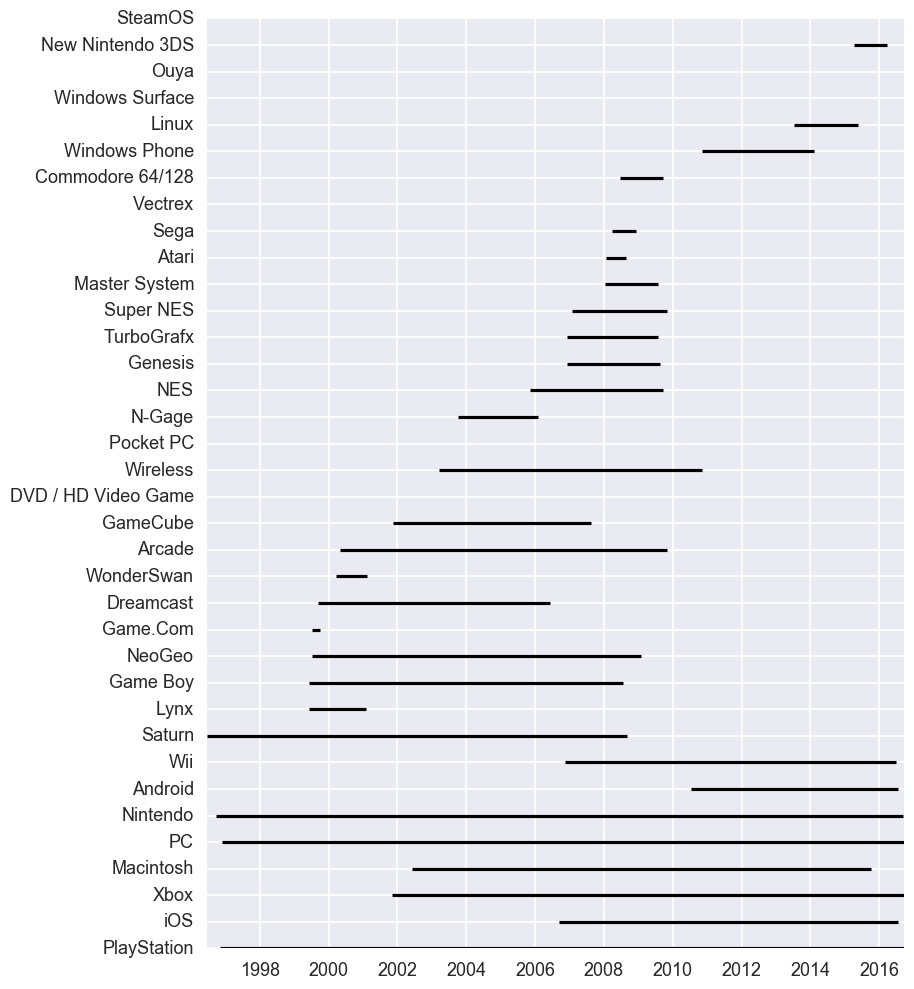

In [21]:
# Plotting timeline of platforms
df_timeline.amin = pd.to_datetime(df_timeline.year_min)\
.astype(datetime)
df_timeline.amax = pd.to_datetime(df_timeline.year_max)\
.astype(datetime)

fig = plt.figure(figsize = (9,12))
pos = np.arange(len(testNames))
plt.yticks(pos, testNames)
matplotlib.rc('ytick', labelsize=9) 
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df_timeline.index, \
                dt.date2num(df_timeline.amin),\
                dt.date2num(df_timeline.amax))

# Models

## Model: Classification

The task of identifying the attributes of a game in order for it to be successful can be seen as a classification problem. For our analysis, we will try out different schemes of classification problems, to find out which performs best:

* Successful vs non-successful game: In this case, we are going to define a threshold θ in the games' score such as games with score s > θ are going to be classified as successful, and games with score s < θ will be classified as non-successful.
* Score phrase classification: Games are going to be classified into the 11 different score phrases which are explained above.
* Masterpiece identification: In this case, we will try to identify the features of the games that are scored with 10, and try to build a classifier that detects only the Masterpieces.



#### Import libraries

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import svm 
from sklearn.cross_validation import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Transform non-numerical features to numerical

In order to be able to use non-numerical columns of the dataset, such as Platform, as features we have to transform them to numerical columns. In order to do so, we utilise sklearn's Label Encoder.

In [23]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X):
        return self.transform(X)

In [64]:
# Encoding the categorical labels into numerical values
games_df_labelcode = MultiColumnLabelEncoder(columns = ['platform','genre','editors_choice','Publisher']).fit_transform(games_df)
games_df_labelcode['score'] = games_df_labelcode['score'].astype(int)

#### Selection of input features

We selected the features that follow as input features. It can be observed that the release_year is not a part of the input, as our client is going to release the games in the future, so the past years are irrelevant.

In [25]:
features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']]
features_val = features.values

### Successful vs non-successful game

For this classification problem, games with scores 0-7 are going to be treated as non-successful games, while games with scores 8-10 are considered successful.

We are going to test 3 different classification algorithms:
* Logistic Regression
* SVM
* Random Forests

#### Logistic Regression

We define success for a game as having a score above 7. Firstly we have to replace the score values into 0 for failure and 1 for success.

In [26]:
# Group score between 0-7 as 0 and 8-10 as 1
target_binary = games_df_labelcode['score'].astype(int).replace([0,1,2,3,4,5,6,7], 0)
target_binary = target_binary.replace([8,9,10], 1)

In [27]:
logReg_binary = LogisticRegression()
logReg_binary = logReg_binary.fit(features_val, target_binary)
logReg_binary

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We use cross validation to train our model. The original data set is randomly partitioned into 10 equal size subsamples where a single subsample is retained as the validation data for testing the model, and the remaining 9 subsamples are used as training data. The cross-validation process is then repeated 10 times, with each of the 10 subsamples used exactly once as the validation data. 

In [28]:
# 10-fold cross validation
scores_logreg_binary = cross_validation.cross_val_score(logReg_binary, features_val, target_binary, cv=10)

In [29]:
# model score
print('LogisticRegression:', scores_logreg_binary.mean())

LogisticRegression: 0.832016394938


With the Logistic Regression model, we have an 83% accuracy.

#### SVM

In the case of SVMs we are following a similar procedure as before.

In [30]:
# define a function to do cross validation
def svm_cross_validation(train_features,train_target, svcClf):
    scores = cross_validation.cross_val_score(svcClf, train_features, train_target, cv=10)
    return scores

# define a function to train and predict model using cross validation
# and output accuracy
def svc(train_features, train_target,svcClf):
    scores = svm_cross_validation(train_features, train_target, svcClf)
    print("SVC:", scores.mean())

In [31]:
# train_target is 'score' label
train_target = games_df_labelcode['score'].values

# train_binary uses '0' and '1' to replace label
train_binary = games_df_labelcode['score'].astype(int).replace([0,1,2,3,4,5,6,7], 0)
train_binary = train_binary.replace([8,9,10], 1)

In [32]:
# select training features
train_features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']].values

In [33]:
# use SVC algorithm
svcClf = svm.SVC()
train_features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']].values
svc(train_features, train_binary, svcClf)

SVC: 0.695579689632


In [34]:
# tune 'C' value
svcClf = svm.SVC(C=5)
train_features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']].values
svc(train_features, train_binary, svcClf)

SVC: 0.700611868862


After changing the C value, which is the weight of regularization, we can get to 70% accuracy.

#### Random Forests

Finally, we used Random Forests for the same task.

In [35]:
# using threshold: 0-7 labeled as 0, 8-10 labeled as 1
target_threshold = games_df_labelcode['score'].astype(int).replace([0,1,2,3,4,5,6,7], 0)
target_threshold = target_threshold.replace([8,9,10], 1)

In [36]:
model_threshold = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_threshold.fit(features, target_threshold)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [37]:
model_threshold.oob_score_

0.80764446454823025

The oob score of the model is 80%.

In [38]:
for feature, importance in zip(features, model_threshold.feature_importances_):
    print (feature, ":", importance)

genre : 0.121077685065
platform : 0.0774606995926
Publisher : 0.238250150829
release_month : 0.105419252243
editors_choice : 0.45779221227


As we can see above, the most important features are editors_choice and Publisher, followed by genre. If we remove editors_choice from our input data, the oob score of the model drops to 69% as follows.

In [39]:
# features without editors choice
features = games_df_labelcode[['genre','platform','Publisher','release_year','release_month']]

In [40]:
model_threshold.fit(features, target_threshold)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [41]:
model_threshold.oob_score_

0.69806626710392405

In [42]:
for feature, importance in zip(features, model_threshold.feature_importances_):
    print (feature, ":", importance)

genre : 0.192009133222
platform : 0.116205602882
Publisher : 0.305785022165
release_year : 0.181496120512
release_month : 0.204504121219


### Score phrase classification

For the score phrase classification, we tried to identify the exact score of the games using the same 3 models as on the binary case. Unfortunately this did not yield very good results, as the data seem to be not sufficient enough for a 11-class classification.

#### Logistic Regression

In [43]:
# Selecting features
features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']]
target = games_df_labelcode['score']
features_val = features.values
target_val = target.values

In [44]:
# Logistic Regression
logReg = LogisticRegression()
logReg = logReg.fit(features_val, target_val)

In [45]:
# 10-fold cross validation
scores_logreg = cross_validation.cross_val_score(logReg, features_val, target_val, cv=10)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [46]:
# model score
print('LogisticRegression:', scores_logreg.mean())

LogisticRegression: 0.354569005633


#### SVM

In [47]:
# mtlti classes, one-against-one
svcClf = svm.SVC(decision_function_shape='ovo')
train_features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']].values
svc(train_features, train_target, svcClf)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


SVC: 0.287416763889


#### Random Forest

In [48]:
features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']]
target = games_df_labelcode['score']


In [49]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)

model.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [50]:
model.oob_score_

0.35372611104828677

In [51]:
for feature, importance in zip(features, model.feature_importances_):
    print (feature, ":", importance)

genre : 0.193704787565
platform : 0.118056170198
Publisher : 0.384260849009
release_month : 0.198873834659
editors_choice : 0.105104358569


#### Masterpiece identification

Lastly, we tried to identify only the masterpieces -the games that scored 10- using Random Forests.

In [52]:
features = games_df_labelcode[['genre','platform','Publisher','release_month','editors_choice']]

# only masterpiece is labeled as 1
target_masterpiece = games_df_labelcode['score'].astype(int).replace([0,1,2,3,4,5,6,7, 8, 9], 0)
target_masterpiece = target_masterpiece.replace([10], 1)

In [53]:
model_masterpiece = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_masterpiece.fit(features, target_masterpiece)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [54]:
model_masterpiece.oob_score_

0.99672056994232727

In [55]:
for feature, importance in zip(features, model_masterpiece.feature_importances_):
    print (feature, ":", importance)

genre : 0.177200695036
platform : 0.141086425647
Publisher : 0.328270838557
release_month : 0.318623463191
editors_choice : 0.0348185775696


We get a really high oob score, which is close to 100%. This, however, is a result of a heavily unbalanced data set.

## Model: Clustering

We tried to use our dataset to perform Clustering, in order to identify a cluster of successful games, and a cluster of unsuccessful ones.

We used K-means clustering and Agglomerative Clustering.


##### Import libraries

In [56]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### K-means clustering

We used K-means clustering method to form clusters of a combination of different features of games (such as genres, platforms, publishers) belonging to same / similar scores.

In [57]:
km_clust = KMeans(n_clusters=2)
km_clust_df = games_df
km_clust.fit(features)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [58]:
pca = PCA(n_components=2).fit(features)
km_clust_df_2d = pca.transform(features)
km_labels = km_clust.labels_


In order to visualise the results, we used PCA to perform dimensionality reduction to 2d.

<function matplotlib.pyplot.show>

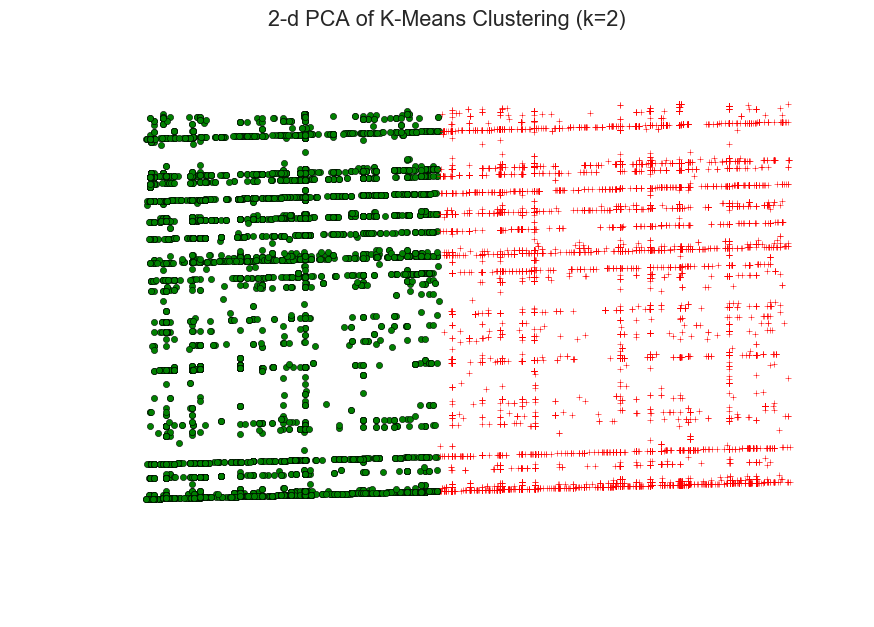

In [59]:
for i in range(0, km_clust_df_2d.shape[0]):
    if km_labels[i] == 0:
        c1 = plt.scatter(km_clust_df_2d[i,0],km_clust_df_2d[i,1],c='r',marker='+')
    elif km_labels[i] == 1:
        c2 = plt.scatter(km_clust_df_2d[i,0],km_clust_df_2d[i,1],c='g',marker='o')
plt.axis("off")
plt.title("2-d PCA of K-Means Clustering (k=2)")

plt.show


### Agglomerative clustering
We also aim to use agglomerative clustering on a combination of different features of games (such as genres, platforms, publishers) belonging to scores and to summarise the process by a hierarchical tree.

In [60]:
clust = AgglomerativeClustering(n_clusters=2)
clust_df = games_df
clust.fit(features)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x1046300d0>)

In [61]:
pca = PCA(n_components=2).fit(features)
clust_df_2d = pca.transform(features)
labels = clust.labels_


<function matplotlib.pyplot.show>

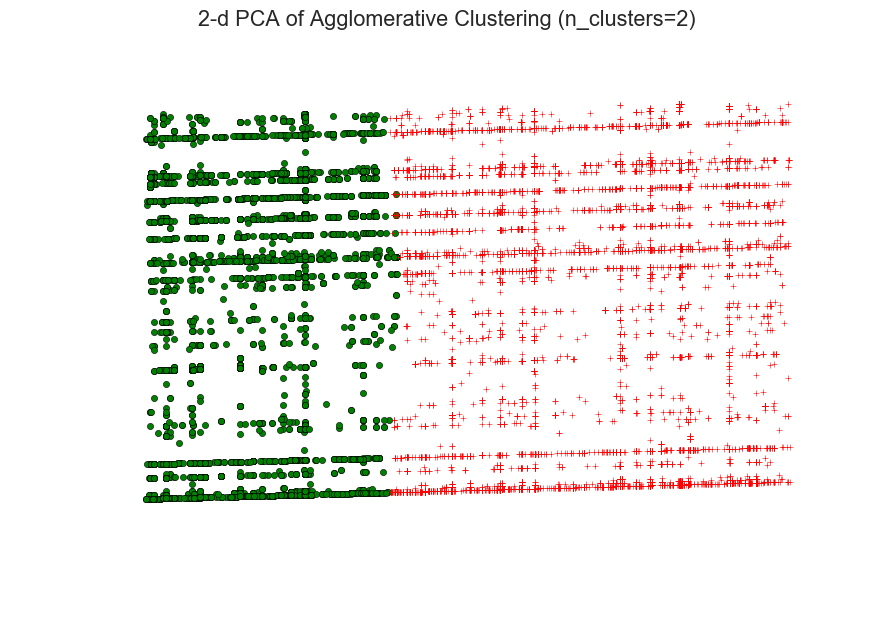

In [86]:
for i in range(0, clust_df_2d.shape[0]):
    if labels[i] == 0:
        c1 = plt.scatter(clust_df_2d[i,0],clust_df_2d[i,1],c='r',marker='+')
    elif labels[i] == 1:
        c2 = plt.scatter(clust_df_2d[i,0],clust_df_2d[i,1],c='g',marker='o')
plt.axis("off")
plt.title("2-d PCA of Agglomerative Clustering (n_clusters=2)")


plt.show


### Evaluation

In order to evaluate our clustering, we used Dimensionality Reduction to visualise the input data. Succsessful games are green dots, and unsuccessful ones are red crosses. As we can see, none of the above algorithms cluster the data as seen on the plot below.

<function matplotlib.pyplot.show>

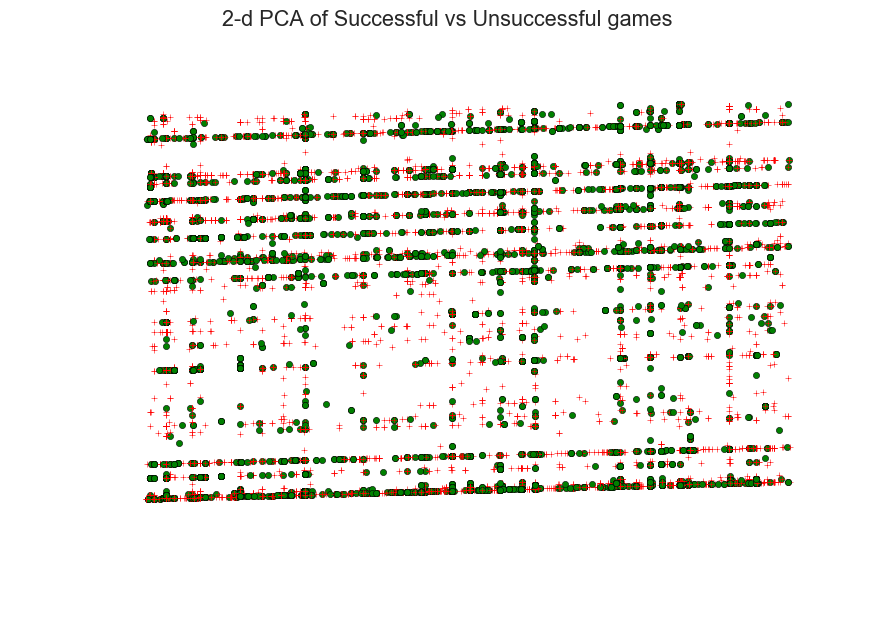

In [85]:
targets = target_threshold.values
for i in range(0, clust_df_2d.shape[0]):
    if targets[i] == 0:
        c1 = plt.scatter(clust_df_2d[i,0],clust_df_2d[i,1],c='r',marker='+')
    elif targets[i] == 1:
        c2 = plt.scatter(clust_df_2d[i,0],clust_df_2d[i,1],c='g',marker='o')
plt.axis("off")
plt.title("2-d PCA of Successful vs Unsuccessful games")


plt.show


### Conclusion

In this work, we had at our disposal a dataset of games reviews. Our client, a games publisher, is interested in expanding in new platform and genres, and would like to know the combination of games that are more likely to succeed.

We tried different classification algorithms, in 3 different scenarios and we also tried to cluster our input data.

As seen on the analysis above, our best models were the classification models that were built to distinguish between successful and unsuccessful games, using either Logistic Regression or Decision Trees. What we would propose to our client is to use one of our classifiers in order to predict whether the game they plan on creating will succeed or not.

The most important feature that defines the success of a game is the 'Editor's Choice' of ign.com followed by its 'Publisher'. What we would advise our client is to get in touch with ign.com, and try to understand what are the elements that they look for in games in order to include them into their 'Editor's Choice' list. Moreover our client would be advised to partner with one of the highest scoring Publishers, such as Rockstar Games.

Lastly, since the next most important factor in the success of a game is the Genre, we would advise our client to focus on hig